In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [3]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)
stays = [
        get_stay(  0.00,  6.00,-1.00), #home
        get_stay(  7.50, 16.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))


dup_mask = get_mask_with_duplicates(time, 0.05, 0.3)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.02, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

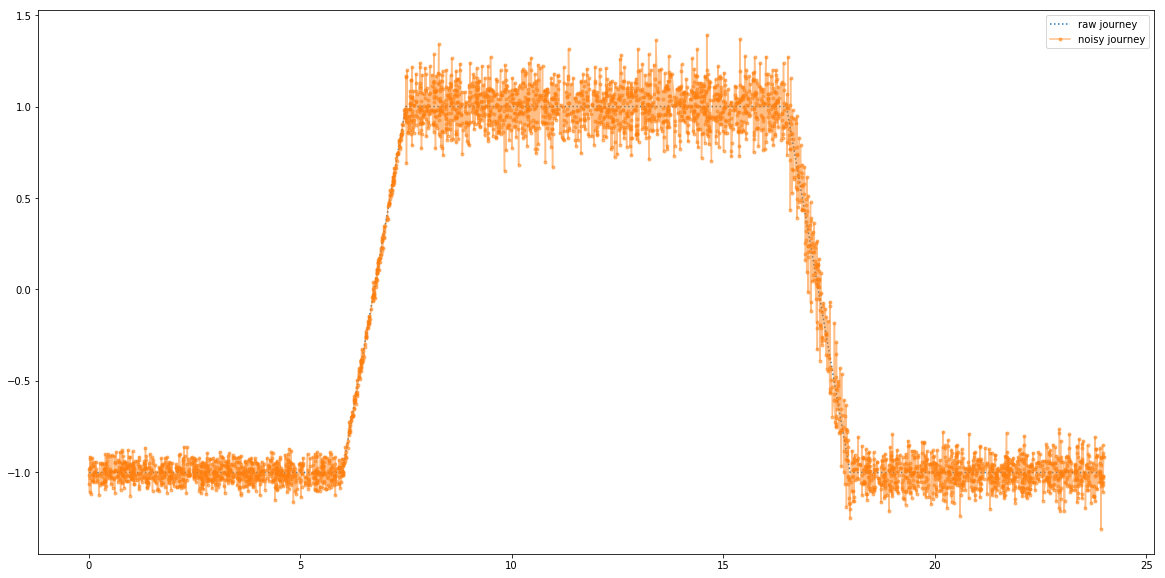

In [4]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend();

**Figure** in the above plot, time is on the "x"-axis. An interpretation of this motion, is that the user is initially making a "stay" at a location near $x=-1$, then makes another stay at $x=1$, ending with a return to the initial location. As with all of this data, there is an intrinsic noise that must be considered.

# Goal: Stay detection and positioning

The goal is to identify stays by their beginnings and ends, and associate them to a position. This effectively means to optimally match clusters of points with flat lines.

For a set of events within a cluster $\mathcal{C}_l =  \{e_i \; | \; i = [m,n]_l \subset [0,N-1]\}$, a "flat line" has $|\mathbf{x}_m-\mathbf{x}_n| = 0$. Again, this is easiest to see in 1D but it also holds in 2D.


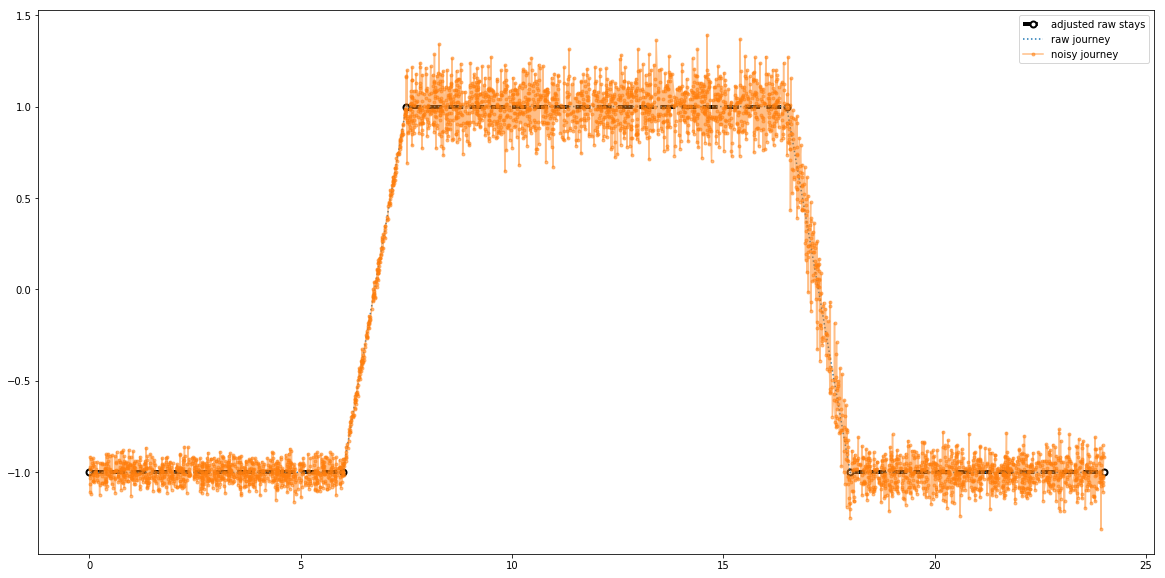

In [5]:
plt.figure(figsize=(20,10))

plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

plt.legend();
plt.grid(visible=False);

# Strategy

To find the stays, we consider some requirements.

Firstly, there are two main requirements (previously noted):
1. identify the start/stop of a stay
2. estimate a dominant location, _ie_ the "central location" of the stay
    * this is where the agent spends the majority of the time, _e.g._ within a building, at a park, etc.

Then, there are some minor rquirements:
1. the clusters should contain a minimum number of points
2. the duration between the first and last points should exceed $\Delta t$
3. the clusters should be as long (in time) as possible
    * if there is a sufficient temporal break between two consecutive events without a significant location change, then on must specify how this is to be dealt with.
4. the clusters should contain as many events as possible

One additional requirement which affects all of the above: **cluster outliers should be identified and ignored** 
* outliers can change the central location and also the beginning/ending of the clusters
* from the calculation of the central location
    * counting them could still help in identifying a cluster wihtout using their position
    
All of these must be considered together.

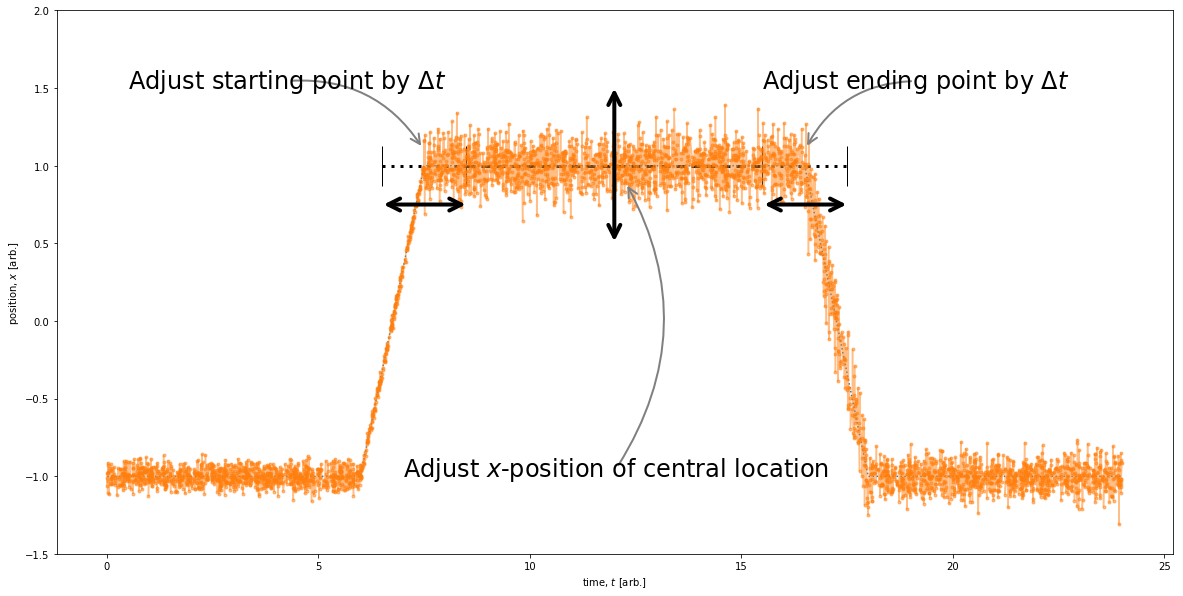

In [6]:
plt.figure(figsize=(20,10))
begin = t_segs[3]+1
begin_buff = begin-2
end = t_segs[4]-1
end_buff = end+2

loc = x_segs[3]

plt.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)

plt.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
plt.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

#plt.plot(t_segs[3:5], x_segs[3:5], '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

# interface tracking profiles
arrowprops=dict(arrowstyle="<->", 
                shrinkA=0.5,
                mutation_scale=30.0,
                connectionstyle="arc3", linewidth=4.0)
# the arrows
arrowcentery = 1.0
arrowcenterx = 12
arrowcenterh = 0.5
plt.annotate("", xy=(arrowcenterx, arrowcentery-arrowcenterh), xytext=(arrowcenterx, arrowcentery+arrowcenterh),
             arrowprops=arrowprops)

dt_arrowcentery = 0.25
plt.annotate("", xy=(begin_buff, arrowcentery-dt_arrowcentery), xytext=(begin, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)

plt.annotate("", xy=(end, arrowcentery-dt_arrowcentery), xytext=(end_buff, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)


mid_point = lambda x1,x2: 0.5*(x1+x2)

delta_t_texty = 1.5
plt.annotate(r"Adjust starting point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(begin,begin_buff), 1.1), xycoords='data',
            xytext=(begin-8,delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=-0.3", linewidth=2.0
                            ),
            )
plt.annotate(r"Adjust ending point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(end,end_buff), 1.1), xycoords='data',
            xytext=(end, delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

plt.annotate(r"Adjust $x$-position of central location",fontsize= 24,
            xy=(arrowcenterx+0.25, arrowcentery-0.1), xycoords='data',
            xytext=(arrowcenterx-5, arrowcentery-2.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

'''plt.text(0, 0.1, r'$\delta$',
         {'color': 'black', 'fontsize': 24, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
'''
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False);

This clearly defines an optimization problem: 
* maximize the length of the fit line, while 
    * mimimizing its error by adjusting its position ($\mathrm{x}_{\mathrm{opt.}}$) and end-regions ($t_{\mathrm{start}}, t_{\mathrm{stop}}$)
    * ignoring the outliers.

**Notes** 

* When the error is the mean squared error: $\epsilon := \sqrt{ \frac{1}{N}\sum^N_i(\mathrm{x}_i-\mathrm{x}_{\mathrm{opt.}})^2}$; 
    * this simplifies the position since the mean (or "centroid") is the value of $\mathrm{x}_{\mathrm{opt.}}$ which minimizes this error, leaving only the adjustment of the end-regions and outliers for the optimization task.

This suggests that there is at least a solution to this problem: 
One could consider all possible combinations of subsequences and all possible combinations of their outliers, and measure error, and then pick any from the set of lowest error subsequence-outlier combination fits. However, this is similar to the maximum subarray problem, and in the worst case it would be $\mathcal{O}(n^3)$.

It's countably finite, but impractical approach; itcan be a benchmark to compare all other algorithms which aim to do the same within some acceptable error.

### The Box

In [7]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

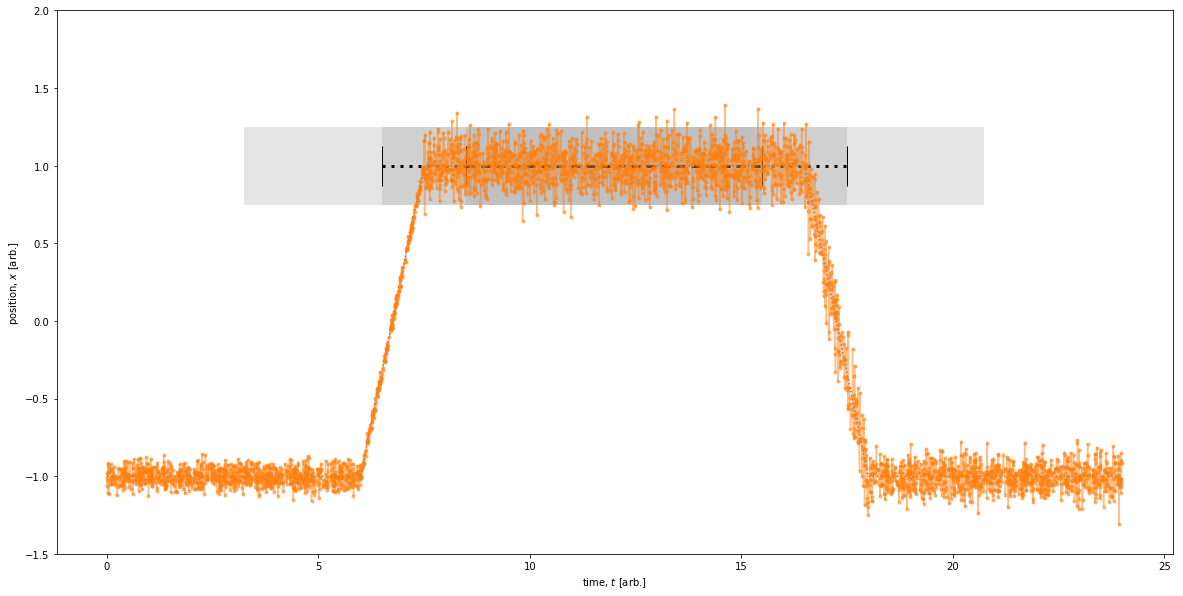

In [8]:
eps = 0.25
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)

ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

#plt.plot(t_segs[3:5], x_segs[3:5], '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# Create patch collection with specified colour/alpha
pc = PatchCollection([rect_outer2, rect_outer,rect_inner], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)

# Add collection to axes
ax.add_collection(pc)

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False);

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

### Box method

In [9]:
box_start = np.where((time_sub < 12.2) & (time_sub > 11.8))[0].min()
box_end = np.where((time_sub < 13.0) & (time_sub > 12.5))[0].max()

In [10]:
def get_counts(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    
    def meth(sub_arr):
        
        return np.where((sub_arr < upper) & (sub_arr > lower))[0].size
    
    return meth
    

In [11]:
def get_thresh_mean(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    
    def meth(sub_arr):
        
        mask =  np.where((sub_arr < upper) & (sub_arr > lower))
    
        return np.mean(sub_arr[mask])
        
    return meth
    

In [12]:
new_start, new_end = box_start, box_end

mean = np.mean(noise_journey_sub[new_start:new_end])
eps = 0.25


time_thresh = 5/12
tdiffs2 = [time_sub[new_end]-time_sub[new_start]]
counts2 = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]
means = [mean]

while (new_start > 1) & (new_end < len(time_sub)-1):
    
    count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])
    
    counts2.append(count)
        
    new_start -= 1
    new_end += 1
    
    mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])
    means.append(mean)    
    
    tdiffs2.append(time_sub[new_end]-time_sub[new_start])
    #break
    


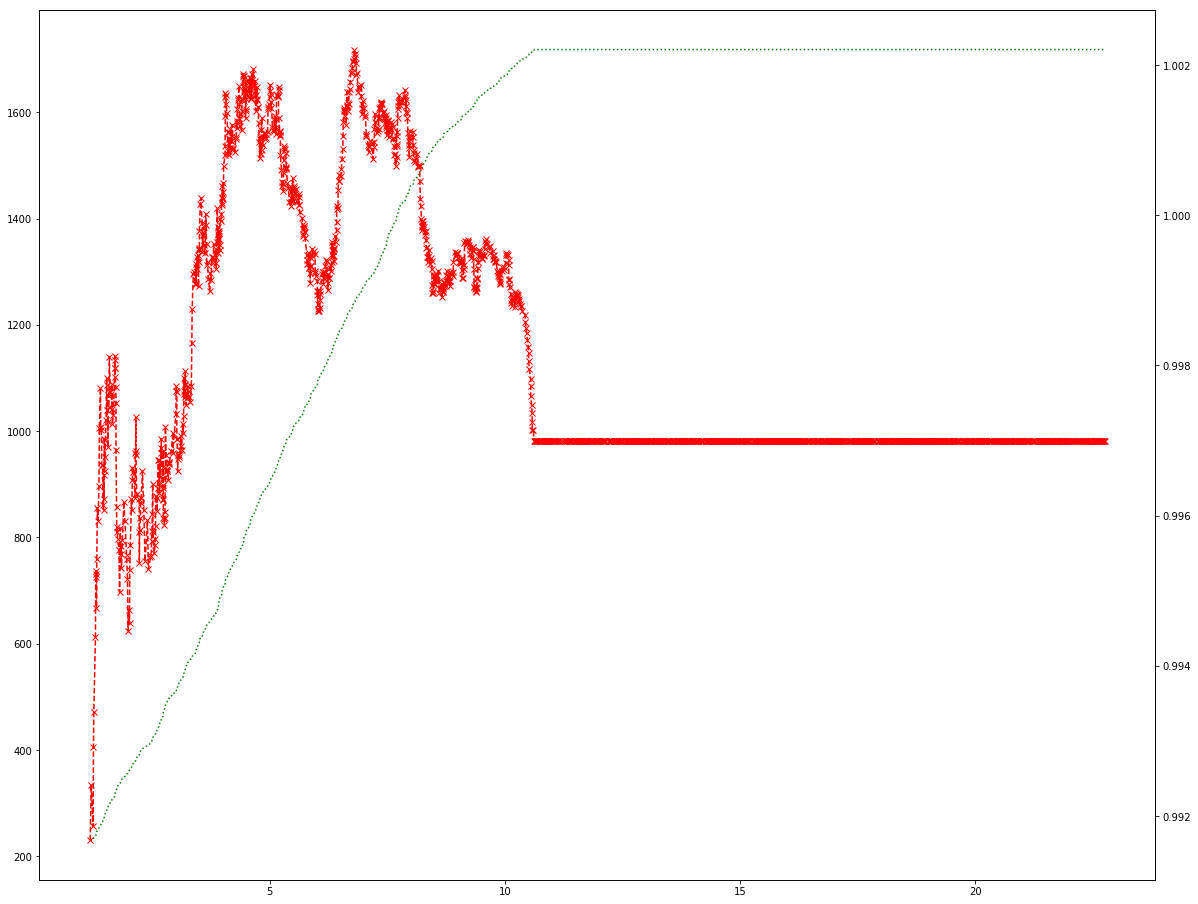

In [14]:

fig, ax = plt.subplots(1,1,figsize=[20,16])
ax.plot(tdiffs2, counts2, 'g:')
axt = ax.twinx()
axt.plot(tdiffs2, means, 'rx--')

In [16]:
timepoint = 5.0

box_start = np.where((time_sub < (timepoint)) & (time_sub > (timepoint-time_thresh)))[0].min()
box_end = np.where((time_sub < (timepoint+time_thresh)) & (time_sub > (timepoint)))[0].max()    

new_start, new_end = box_start, box_end

mean = np.mean(noise_journey_sub[new_start:new_end])


eps = 0.25

time_thresh = 5/12
tdiffs2 = [time_sub[new_end]-time_sub[new_start]]
counts2 = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]

means = [mean]

while (new_start > 1) | (new_end < len(time_sub)-1):
    
    count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])
    
    counts2.append(count)
        
    if (new_start > 1):
        new_start -= 1
    if (new_end < len(time_sub)-1):
        new_end += 1
    
    mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])
    means.append(mean)    
    
    tdiffs2.append(time_sub[new_end]-time_sub[new_start])
    
    count_thresh = 50
    if len(means)>count_thresh:
        m0 = means[-count_thresh]
        if all([m == m0 for m in means[-count_thresh:]]):
            break
    


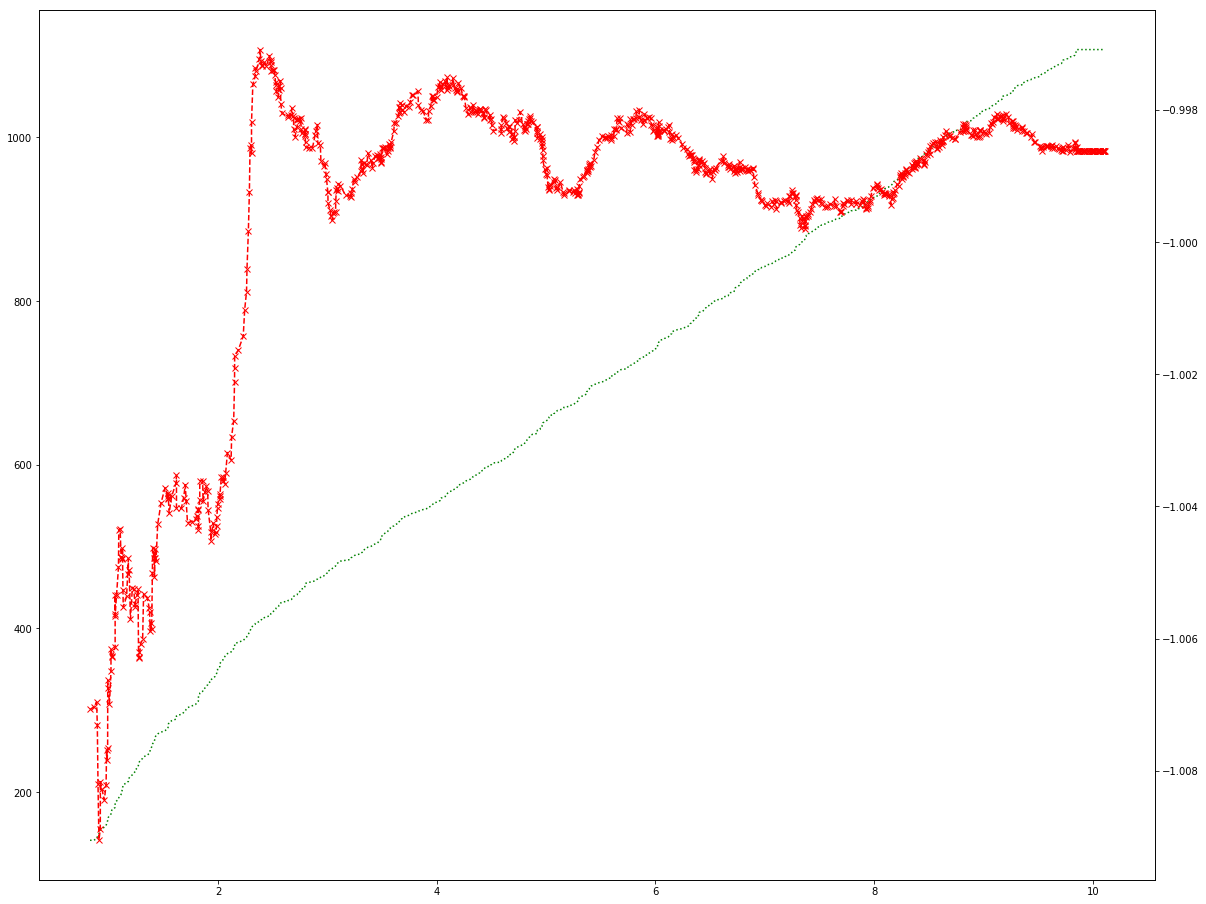

In [17]:

fig, ax = plt.subplots(1,1,figsize=[20,16])
ax.plot(tdiffs2, counts2, 'g:')
axt = ax.twinx()
axt.plot(tdiffs2, means, 'rx--')

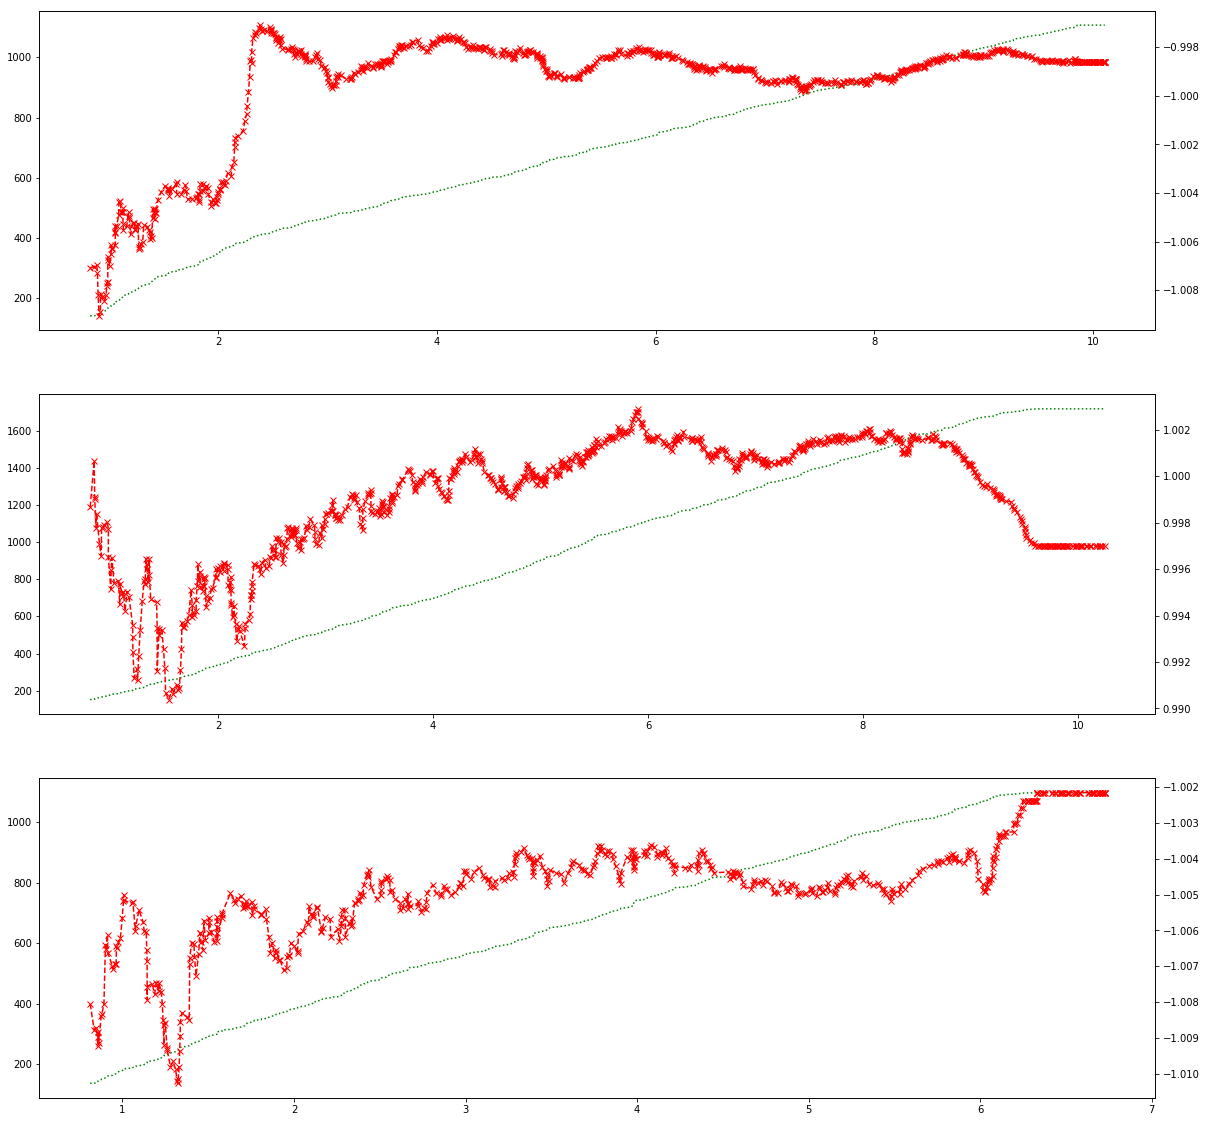

In [18]:
fig, axs = plt.subplots(3,1,figsize=[20,20])


eps = 0.25

time_thresh = 5/12


axn = 0

for timepoint in [5, 12, 21]:
    
    box_start = np.where((time_sub < (timepoint)) & (time_sub > (timepoint-time_thresh)))[0].min()
    box_end = np.where((time_sub < (timepoint+time_thresh)) & (time_sub > (timepoint)))[0].max()    
    
    new_start, new_end = box_start, box_end
    

    mean = np.mean(noise_journey_sub[new_start:new_end])


    counts = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]
    tdiffs = [time_sub[new_end]-time_sub[new_start]]

    lower_factor = 1.0
    upper_factor =1.0

    while (time_sub[new_start] > 0.1) & (time_sub[new_end] < 23.0):


        t_lower = time_sub[new_start]-lower_factor*time_thresh
        t_upper = time_sub[new_end]+upper_factor*time_thresh

        #print(time_sub[new_start], t_lower)

        check_start = np.where((time_sub < time_sub[new_end]) & (time_sub > t_lower))[0].min()

        if check_start != new_start:
            new_start = check_start
            lower_factor = 1.0
        else:
            lower_factor += 1


        check_end = np.where((time_sub < t_upper) & (time_sub > time_sub[new_start]))[0].max() 

        if check_end != new_end:
            new_end = check_end
            upper_factor = 1.0
        else:
            upper_factor += 1

        count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])

        #print(t_lower, t_upper, check_start, new_start, check_end, new_end)

        counts.append(count)
        tdiffs.append(t_upper-t_lower)
        #print(count)

        mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])

        count_thresh = 50
        if len(counts)>count_thresh:
            m0 = counts[-count_thresh]
            if all([m == m0 for m in counts[-count_thresh:]]):
                break

    new_start, new_end = box_start, box_end

    mean = np.mean(noise_journey_sub[new_start:new_end])
    eps = 0.25


    time_thresh = 5/12
    tdiffs2 = [time_sub[new_end]-time_sub[new_start]]
    counts2 = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]
    means = [mean]

    while (new_start > 1) | (new_end < len(time_sub)-1):

        count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])

        counts2.append(count)

        if (new_start > 1):
            new_start -= 1
        if (new_end < len(time_sub)-1):
            new_end += 1

        mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])
        means.append(mean)    

        tdiffs2.append(time_sub[new_end]-time_sub[new_start])

        count_thresh = 50
        if len(means)>count_thresh:
            m0 = means[-count_thresh]
            if all([m == m0 for m in means[-count_thresh:]]):
                break
     
    ax= axs[axn]
    #ax.plot(tdiffs, counts , 'b.-')
    ax.plot(tdiffs2, counts2, 'g:')
    axt = ax.twinx()    
    #axt.set_ylim(-1.2,1.2)    
    axt.plot(tdiffs2, means, 'rx--')
    axn+=1